In [6]:
!pip install pandas yfinance alpha_vantage scikit-learn pymongo sqlalchemy


Defaulting to user installation because normal site-packages is not writeable
  Using cached SQLAlchemy-2.0.31-cp311-cp311-win_amd64.whl.metadata (9.9 kB)
   ---------------------------------------- 0.0/631.0 kB ? eta -:--:--
   ----- ---------------------------------- 92.2/631.0 kB 2.6 MB/s eta 0:00:01
   -------------- ------------------------- 235.5/631.0 kB 2.9 MB/s eta 0:00:01
   --------------------------- ------------ 430.1/631.0 kB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 631.0/631.0 kB 3.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ----------- ---------------------------- 0.6/2.1 MB 37.8 MB/s eta 0:00:01
   ------------------------- -------------- 1.3/2.1 MB 16.7 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB 16.5 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 12.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/307.7 kB ? eta -:--:--
   ----


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
import pandas as pd
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
# Function to fetch stock data from Yahoo Finance
def fetch_yahoo_finance_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Function to fetch data from Alpha Vantage
def fetch_alpha_vantage_data(ticker, api_key):
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')
    return data

# Function to clean the data
def clean_data(data):
    data = data.drop_duplicates()
    data = data.fillna(method='ffill').fillna(method='bfill')
    return data

# Function to normalize the data
def normalize_data(data):
    scaler = MinMaxScaler()
    normalized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    return normalized_data

# Function to standardize the data
def standardize_data(data):
    scaler = StandardScaler()
    standardized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    return standardized_data

# Function to save DataFrame to MongoDB
def save_to_mongo(collection_name, data, db):
    collection = db[collection_name]
    collection.delete_many({})  # Clear existing data
    collection.insert_many(data.reset_index().to_dict('records'))

# Fetch, clean, normalize, and standardize data
yahoo_data = fetch_yahoo_finance_data('AAPL', '2020-01-01', '2023-01-01')
alpha_data = fetch_alpha_vantage_data('AAPL', 'YOUR_ALPHA_VANTAGE_API_KEY')  # Replace with your API key
cleaned_yahoo_data = clean_data(yahoo_data)
cleaned_alpha_data = clean_data(alpha_data)
normalized_yahoo_data = normalize_data(cleaned_yahoo_data)
standardized_yahoo_data = standardize_data(cleaned_yahoo_data)

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['financial_data']

# Save the data to MongoDB
save_to_mongo('yahoo_finance', cleaned_yahoo_data, db)
save_to_mongo('alpha_vantage', cleaned_alpha_data, db)
save_to_mongo('normalized_yahoo_finance', normalized_yahoo_data, db)
save_to_mongo('standardized_yahoo_finance', standardized_yahoo_data, db)

# Verify data storage
for doc in db['yahoo_finance'].find().limit(5):
    print(doc)


In [ ]:
# Load normalized data from MongoDB
normalized_yahoo_data = pd.DataFrame(list(db['normalized_yahoo_finance'].find()))

# Drop MongoDB-specific ID column
if '_id' in normalized_yahoo_data:
    normalized_yahoo_data.drop('_id', axis=1, inplace=True)


In [48]:
# Feature selection (use 'Close' prices for simplicity)
X = normalized_yahoo_data.drop(['Close', 'Date'], axis=1)  # Ensure no datetime columns
y = normalized_yahoo_data['Close']


In [49]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [51]:
# Make predictions
y_pred = model.predict(X_test)


In [52]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 8.01354382517839e-06
R-squared: 0.9998747067596317


In [53]:
# Save the predictions to MongoDB
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
save_to_mongo('predictions', predictions, db)


In [54]:
# Verify predictions storage
for doc in db['predictions'].find().limit(5):
    print(doc)


{'_id': ObjectId('66ac68c8e0c3ee277f44a6b5'), 'index': 408, 'Actual': 0.7546806405958996, 'Predicted': 0.7507830184570073}
{'_id': ObjectId('66ac68c8e0c3ee277f44a6b6'), 'index': 97, 'Actual': 0.18361231386470078, 'Predicted': 0.1849929649597651}
{'_id': ObjectId('66ac68c8e0c3ee277f44a6b7'), 'index': 424, 'Actual': 0.7863680996746415, 'Predicted': 0.7840214566259935}
{'_id': ObjectId('66ac68c8e0c3ee277f44a6b8'), 'index': 584, 'Actual': 0.7979630468694806, 'Predicted': 0.8002472353690098}
{'_id': ObjectId('66ac68c8e0c3ee277f44a6b9'), 'index': 603, 'Actual': 0.669227904701926, 'Predicted': 0.671002401559096}


In [55]:
def optimize_portfolio(returns):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)
    
    # Generate random portfolios
    num_portfolios = 10000
    results = np.zeros((num_portfolios, num_assets + 2))
    
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        portfolio_sharpe = portfolio_return / portfolio_volatility
        
        results[i, :-2] = weights
        results[i, -2] = portfolio_return
        results[i, -1] = portfolio_volatility
        
    # Convert results to DataFrame
    columns = ['Asset ' + str(i) for i in range(num_assets)] + ['Return', 'Volatility']
    portfolio_results = pd.DataFrame(results, columns=columns)
    
    return portfolio_results

# Calculate returns
returns = standardized_yahoo_data.pct_change().dropna()

# Optimize portfolio
optimized_portfolio = optimize_portfolio(returns)


In [56]:
# Save the optimized portfolio to MongoDB
save_to_mongo('optimized_portfolio', optimized_portfolio, db)


In [57]:
# Verify optimized portfolio storage
for doc in db['optimized_portfolio'].find().limit(5):
    print(doc)


{'_id': ObjectId('66ac68cbe0c3ee277f44a74d'), 'index': 0, 'Asset 0': 0.22049050398964187, 'Asset 1': 0.29656974566456085, 'Asset 2': 0.12593815967062671, 'Asset 3': 0.2086361484959712, 'Asset 4': 0.0567790466429639, 'Asset 5': 0.09158639553623549, 'Return': -0.10778290172405552, 'Volatility': 2.646133468639434}
{'_id': ObjectId('66ac68cbe0c3ee277f44a74e'), 'index': 1, 'Asset 0': 0.015066500423706615, 'Asset 1': 0.14289904174830675, 'Asset 2': 0.1294012427978469, 'Asset 3': 0.1711128602108963, 'Asset 4': 0.22683584215255392, 'Asset 5': 0.3146845126666897, 'Return': -0.11901959379098928, 'Volatility': 4.294774343905613}
{'_id': ObjectId('66ac68cbe0c3ee277f44a74f'), 'index': 2, 'Asset 0': 0.23840812219624324, 'Asset 1': 0.26297137906474655, 'Asset 2': 0.1112249171998092, 'Asset 3': 0.09362233151358218, 'Asset 4': 0.2816021971717128, 'Asset 5': 0.012171052853906064, 'Return': -0.11063354298932085, 'Volatility': 2.608797649448346}
{'_id': ObjectId('66ac68cbe0c3ee277f44a750'), 'index': 3, 'A

In [58]:
def calculate_var_cvar(returns, confidence_level=0.95):
    # Calculate VaR
    var = returns.quantile(1 - confidence_level)
    
    # Calculate CVaR
    cvar = returns[returns <= var].mean()
    
    return var, cvar

# Calculate VaR and CVaR
var, cvar = calculate_var_cvar(returns['Close'])

print(f"Value at Risk (VaR) at 95% confidence level: {var}")
print(f"Conditional Value at Risk (CVaR) at 95% confidence level: {cvar}")


Value at Risk (VaR) at 95% confidence level: -0.5312286384204492
Conditional Value at Risk (CVaR) at 95% confidence level: -2.0255353831889744


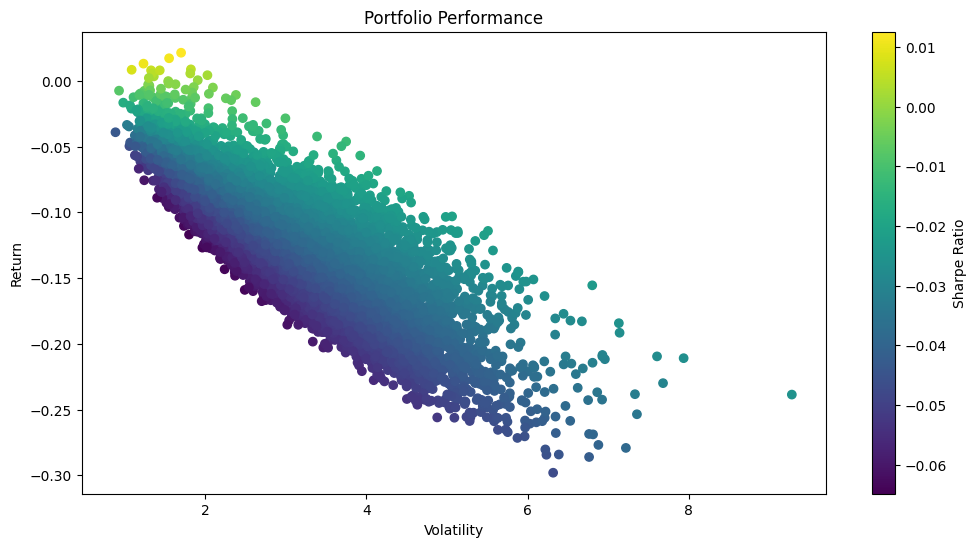

In [59]:
def plot_portfolio_performance(portfolio_results):
    plt.figure(figsize=(12, 6))
    plt.scatter(portfolio_results['Volatility'], portfolio_results['Return'], c=portfolio_results['Return'] / portfolio_results['Volatility'], marker='o')
    plt.title('Portfolio Performance')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

# Plot portfolio performance
plot_portfolio_performance(optimized_portfolio)


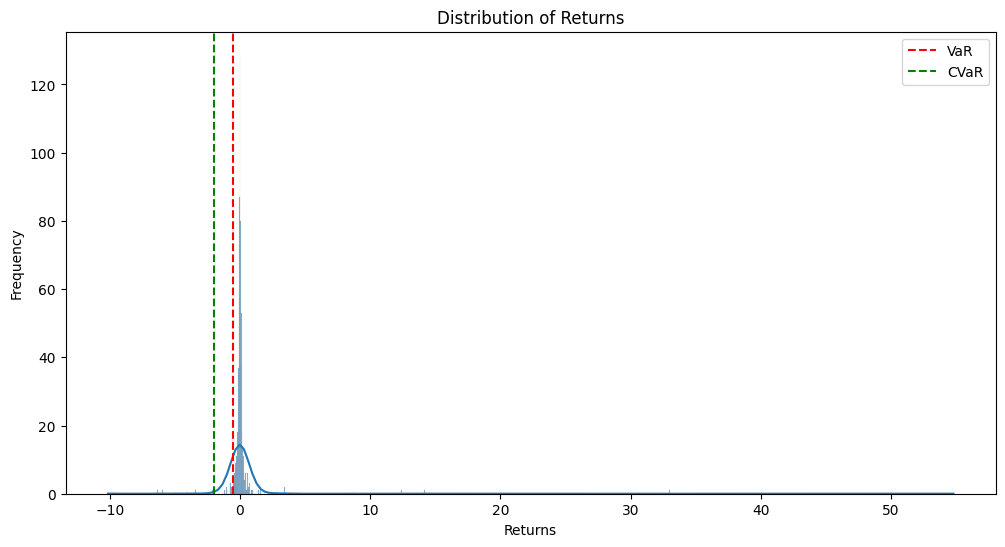

In [60]:
def plot_risk_metrics(returns):
    # Plot distribution of returns
    plt.figure(figsize=(12, 6))
    sns.histplot(returns, kde=True)
    plt.title('Distribution of Returns')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.axvline(x=var, color='r', linestyle='--', label='VaR')
    plt.axvline(x=cvar, color='g', linestyle='--', label='CVaR')
    plt.legend()
    plt.show()

# Plot risk metrics
plot_risk_metrics(returns['Close'])


In [61]:
def generate_recommendations(optimized_portfolio):
    top_portfolios = optimized_portfolio.nlargest(5, 'Return')  # Get top 5 portfolios by return
    recommendations = []
    
    for _, row in top_portfolios.iterrows():
        recommendation = {
            'Weights': row[:-2].to_dict(),
            'Expected Return': row['Return'],
            'Volatility': row['Volatility']
        }
        recommendations.append(recommendation)
    
    return recommendations

# Generate recommendations
recommendations = generate_recommendations(optimized_portfolio)
print(recommendations)


[{'Weights': {'Asset 0': 0.005981485046829353, 'Asset 1': 0.06081143520096531, 'Asset 2': 0.1948543499716878, 'Asset 3': 0.6279433930193079, 'Asset 4': 0.08590172055471287, 'Asset 5': 0.02450761620649686}, 'Expected Return': 0.0214298527457026, 'Volatility': 1.7029078197616132}, {'Weights': {'Asset 0': 0.012224776486062376, 'Asset 1': 0.23245535939844345, 'Asset 2': 0.03225472701340775, 'Asset 3': 0.43358915774787204, 'Asset 4': 0.2561913950372878, 'Asset 5': 0.03328458431692653}, 'Expected Return': 0.017222158353874542, 'Volatility': 1.5540678241917452}, {'Weights': {'Asset 0': 0.0024637425838174246, 'Asset 1': 0.3887085688223929, 'Asset 2': 0.03996462182824298, 'Asset 3': 0.3025416642522394, 'Asset 4': 0.2469245551352021, 'Asset 5': 0.01939684737810505}, 'Expected Return': 0.013121317848703577, 'Volatility': 1.2365261862772754}, {'Weights': {'Asset 0': 0.11430296981847098, 'Asset 1': 0.1959152705280302, 'Asset 2': 0.02449245699764692, 'Asset 3': 0.565901473885954, 'Asset 4': 0.084810

In [62]:
# Save the recommendations to MongoDB
save_to_mongo('recommendations', pd.DataFrame(recommendations), db)


In [63]:
# Verify recommendations storage
for doc in db['recommendations'].find().limit(5):
    print(doc)


{'_id': ObjectId('66ac68d0e0c3ee277f44ce5d'), 'index': 0, 'Weights': {'Asset 0': 0.005981485046829353, 'Asset 1': 0.06081143520096531, 'Asset 2': 0.1948543499716878, 'Asset 3': 0.6279433930193079, 'Asset 4': 0.08590172055471287, 'Asset 5': 0.02450761620649686}, 'Expected Return': 0.0214298527457026, 'Volatility': 1.7029078197616132}
{'_id': ObjectId('66ac68d0e0c3ee277f44ce5e'), 'index': 1, 'Weights': {'Asset 0': 0.012224776486062376, 'Asset 1': 0.23245535939844345, 'Asset 2': 0.03225472701340775, 'Asset 3': 0.43358915774787204, 'Asset 4': 0.2561913950372878, 'Asset 5': 0.03328458431692653}, 'Expected Return': 0.017222158353874542, 'Volatility': 1.5540678241917452}
{'_id': ObjectId('66ac68d0e0c3ee277f44ce5f'), 'index': 2, 'Weights': {'Asset 0': 0.0024637425838174246, 'Asset 1': 0.3887085688223929, 'Asset 2': 0.03996462182824298, 'Asset 3': 0.3025416642522394, 'Asset 4': 0.2469245551352021, 'Asset 5': 0.01939684737810505}, 'Expected Return': 0.013121317848703577, 'Volatility': 1.23652618

{'_id': ObjectId('66ac672be0c3ee277f44a6b0'), 'index': 0, 'Weights': {'Asset 0': 0.041002571762856245, 'Asset 1': 0.36367011630332213, 'Asset 2': 0.033236790629967095, 'Asset 3': 0.5170923090937891, 'Asset 4': 0.039579696784971335, 'Asset 5': 0.005418515425094202}, 'Expected Return': 0.03744413323273299, 'Volatility': 1.3962045277496364}
{'_id': ObjectId('66ac672be0c3ee277f44a6b1'), 'index': 1, 'Weights': {'Asset 0': 0.049950839795835186, 'Asset 1': 0.4184324206486505, 'Asset 2': 0.015825755656854245, 'Asset 3': 0.44253622266393416, 'Asset 4': 0.07298448656453096, 'Asset 5': 0.0002702746701948811}, 'Expected Return': 0.029971356318180174, 'Volatility': 1.2931982421020576}
{'_id': ObjectId('66ac672be0c3ee277f44a6b2'), 'index': 2, 'Weights': {'Asset 0': 0.08082333629037415, 'Asset 1': 0.2970358970000738, 'Asset 2': 0.0058071030638688955, 'Asset 3': 0.5497449892047795, 'Asset 4': 0.04867673500773466, 'Asset 5': 0.017911939433168822}, 'Expected Return': 0.025134023245070206, 'Volatility': 